<a href="https://colab.research.google.com/github/amita-kapoor/COVID-2020/blob/master/Prediction_Covid_19_WorldWide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid 19 cases World Wide Analysis 
Data Source: https://github.com/CSSEGISandData/COVID-19

In [1]:
!pip install geopandas

In [0]:
from datetime import timedelta, date, datetime
#import datetime as dt
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


# Read data 
Data source: [CSSEGISandData](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data)

In [0]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2020, 1, 22)
end_dt = date(2020, 4, 5)
dates = []
for dt in daterange(start_dt, end_dt):
    dates.append(dt.strftime("%m-%d-%Y"))


In [4]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'
df1 = pd.read_csv(url+dates[0]+'.csv')
for dt in tqdm(dates):
  #print(dt)
  df2 = pd.read_csv(url+dt+'.csv')
  if datetime.strptime(dt,"%m-%d-%Y")  > datetime.strptime("03-21-2020", "%m-%d-%Y"): 
    print(dt)
    df2.rename(columns={'Province_State': 'Province/State', 'Country_Region':'Country/Region','Last_Update': 'Last Update'}, inplace = True)
    df2.drop(['FIPS'], axis=1, inplace=True)
    df2.drop(['Admin2'], axis=1, inplace=True)
    df2.drop(['Active'], axis=1, inplace=True)
    df2.drop(['Combined_Key'], axis=1, inplace=True)
  df1 = pd.merge(df1, df2, how='outer' )

 81%|████████▏ | 61/75 [00:24<00:05,  2.56it/s]

03-22-2020


 83%|████████▎ | 62/75 [00:25<00:05,  2.40it/s]

03-23-2020


 84%|████████▍ | 63/75 [00:26<00:07,  1.62it/s]

03-24-2020


 85%|████████▌ | 64/75 [00:26<00:06,  1.72it/s]

03-25-2020


 87%|████████▋ | 65/75 [00:27<00:05,  1.79it/s]

03-26-2020


 88%|████████▊ | 66/75 [00:27<00:04,  1.82it/s]

03-27-2020


 89%|████████▉ | 67/75 [00:28<00:04,  1.85it/s]

03-28-2020


 91%|█████████ | 68/75 [00:28<00:03,  1.85it/s]

03-29-2020


 92%|█████████▏| 69/75 [00:29<00:03,  1.84it/s]

03-30-2020


 93%|█████████▎| 70/75 [00:29<00:02,  1.89it/s]

03-31-2020


 95%|█████████▍| 71/75 [00:30<00:02,  1.92it/s]

04-01-2020


 96%|█████████▌| 72/75 [00:30<00:01,  1.92it/s]

04-02-2020


 97%|█████████▋| 73/75 [00:31<00:01,  1.89it/s]

04-03-2020


 99%|█████████▊| 74/75 [00:32<00:00,  1.42it/s]

04-04-2020


100%|██████████| 75/75 [00:32<00:00,  2.28it/s]

04-05-2020


In [0]:
df1.drop(['Province/State'], axis=1, inplace=True)
df1['Last Update']= pd.to_datetime(df1['Last Update']) 
df1['Last Update'] = df1['Last Update'].dt.date
df1.fillna(0, inplace = True)

In [0]:
dict_country = {'Cote d\'Ivoire': 'Côte d\'Ivoire', 'Martinique':'France', 'Hong Kong':'China',
                'North Korea':'Korea, Democratic People\'s Republic of','Republic of Korea':'South Korea',
                'Korea, South': 'South Korea','US':'United States of America','UK':'United Kingdom',
                'Mainland China':'China','Iran (Islamic Republic of)':'Iran', 'Czech Republic': 'Czechia',
                'Hong Kong SAR': 'Hong Kong','Bosnia and Herzegovina': 'Bosnia and Herz.','Republic of Ireland':'Ireland',
                ' Azerbaijan':'Azerbaijan', 'Andorra':'Italy','Aruba':'Netherlands','Cayman Islands':'United Kingdom',
                'Central African Republic':'Central African Rep.','Channel Islands':'United Kingdom',
                'Congo (Brazzaville)':'Congo','Congo (Kinshasa)':'Congo','Viet Nam':'Vietnam',
                'Equatorial Guinea': 'Eq. Guinea', 'Eswatini':'eSwatini' ,'occupied Palestinian territory':'Palestine',
                'Vatican City':'Italy','The Bahamas':'Bahamas','Taiwan*':'Taiwan','Taipei and environs':'Taiwan','Holy See':'Italy',
                'Saint Martin':'St. Martin','Singapore':'China','Russian Federation':'Russia',
                'Republic of the Congo':'Congo','Republic of Moldova':'Moldova','North Macedonia':'Macedonia',
                'North Ireland':'United Kingdom','Monaco':'Others','Seychelles':'Others','Saint Vincent and the Grenadines':'Others',
                'Antigua and Barbuda':'Others','Bahrain':'Others','Cruise Ship':'Others', 'Curacao':'Others','Dominican Republic':'Dominican Rep.',
                'Faroe Islands': 'Others', 'French Guiana':'Others','Gibraltar':'Others','Guadeloupe':'Others','Guam':'Others','Ivory Coast':'Côte d\'Ivoire'}
for key, value in dict_country.items():
  df1['Country/Region'].replace([key], value,inplace=True)

In [7]:
df1.head()

,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,Lat,Long_
0,China,2020-01-22,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,China,2020-01-22,14.0,0.0,0.0,0.0,0.0,0.0,0.0
2,China,2020-01-22,6.0,0.0,0.0,0.0,0.0,0.0,0.0
3,China,2020-01-22,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,China,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51188 entries, 0 to 51187
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country/Region  51188 non-null  object 
 1   Last Update     51188 non-null  object 
 2   Confirmed       51188 non-null  float64
 3   Deaths          51188 non-null  float64
 4   Recovered       51188 non-null  float64
 5   Latitude        51188 non-null  float64
 6   Longitude       51188 non-null  float64
 7   Lat             51188 non-null  float64
 8   Long_           51188 non-null  float64
dtypes: float64(7), object(2)
memory usage: 3.9+ MB


In [9]:
df1.head()

,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,Lat,Long_
0,China,2020-01-22,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,China,2020-01-22,14.0,0.0,0.0,0.0,0.0,0.0,0.0
2,China,2020-01-22,6.0,0.0,0.0,0.0,0.0,0.0,0.0
3,China,2020-01-22,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,China,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df1 = pd.pivot_table(df1, index=['Country/Region','Last Update'], aggfunc={'Confirmed':np.sum, 'Deaths':np.sum,\
                                                                           'Recovered':np.sum,'Latitude':np.max,\
                                                                           'Longitude':np.max})

In [11]:
df1.head(10)


Confirmed  Deaths  Latitude  Longitude  Recovered
Country/Region Last Update                                                   
Afghanistan    2020-02-24         1.0     0.0   33.0000      65.00        0.0
               2020-03-08         4.0     0.0   33.0000      65.00        0.0
               2020-03-10         5.0     0.0   33.0000      65.00        0.0
               2020-03-11        14.0     0.0   33.0000      65.00        0.0
               2020-03-14        11.0     0.0   33.9391      67.71        0.0
               2020-03-15        16.0     0.0   33.9391      67.71        0.0
               2020-03-16        21.0     0.0   33.9391      67.71        1.0
               2020-03-17        22.0     0.0   33.9391      67.71        1.0
               2020-03-20        24.0     0.0   33.9391      67.71        1.0
               2020-03-22        40.0     1.0    0.0000       0.00        1.0

In [0]:
def plot_percent(df_country, Country):
  ## Plotting the percentage
  plt.rcParams.update({'font.size': 22})
  plt.rcParams["figure.figsize"] = [16,10]
  plt.rc('xtick',labelsize=14, )
  plt.rc('ytick',labelsize=14)
  ax = df_country.plot('Last Update', ['deceased_percent', 'recovered_percent'])
  #ax = df_country.plot('Last Update', 'deceased_percent')
  ax.set_ylabel("Percentage", fontname="Arial", fontsize=18)
  ax.set_xlabel("Date", fontname="Arial", fontsize=18)
  ax.legend(loc=0, prop={'size': 20})
  ax.set_title("Percentage deceased, recovered and severe in "+ Country, fontsize=20)
  plt.xticks(rotation=45)

In [0]:
def plot_total(df1, Country, graph='Active_recovered', bar=False):
  df_country = df1.loc[Country]
  df_country.reset_index(inplace=True)
  #df_country.drop(df_country.tail(1).index,inplace=True)
  
  ## Plotting the percentage
  plt.rcParams.update({'font.size': 22})
  plt.rcParams["figure.figsize"] = [16,10]
  plt.rc('xtick',labelsize=14, )
  plt.rc('ytick',labelsize=14)
  
  if graph == 'Active_recovered':
    df_country['Active'] = (df_country['Confirmed']- df_country['Deaths']-df_country['Recovered'])
    if bar:
      ax = df_country.plot.bar(x='Last Update', y=['Active', 'Recovered', 'Deaths'],stacked=True)
    else:
      ax = df_country.plot('Last Update', ['Active', 'Recovered', 'Deaths'])
    ax.set_ylabel("Number", fontname="Arial", fontsize=18)
    ax.set_xlabel("Date", fontname="Arial", fontsize=18)
    ax.legend(loc=0, prop={'size': 20})
    ax.set_title("Active, Recovered and Deaths in  "+ Country, fontsize=20)
    
  
  if graph == 'daily_increase':
    df_country['daily_increase'] = df_country['Confirmed'] - df_country['Confirmed'].shift(1)
    ax = df_country.plot.bar(x='Last Update', y=['daily_increase'])
    ax.set_ylabel("Daily increase", fontname="Arial", fontsize=18)
    ax.set_xlabel("Date", fontname="Arial", fontsize=18)
    ax.legend(loc=0, prop={'size': 20})
    ax.set_title("Daily Increase in "+ Country, fontsize=20)
    

  if graph == 'percent':
    df_country['deceased_percent'] = (df_country['Deaths']/ df_country['Confirmed'])*100
    df_country['recovered_percent'] = (df_country['Recovered']/ df_country['Confirmed'])*100
    ax = df_country.plot('Last Update', ['deceased_percent', 'recovered_percent'])
     #ax = df_country.plot('Last Update', 'deceased_percent')
    ax.set_ylabel("Percentage", fontname="Arial", fontsize=18)
    ax.set_xlabel("Date", fontname="Arial", fontsize=18)
    ax.legend(loc=0, prop={'size': 20})
    ax.set_title("Percentage deceased, recovered and severe in "+ Country, fontsize=20)
  
  plt.xticks(rotation=45)


## Summarizing data from all countries.


In [0]:
from scipy.optimize import curve_fit
def prediction_country_summary(Country, df1, plot= False):
  """
  function summarizes data for each country 
  """
  df_final = df1.copy()
  df_country = df_final.loc[Country]
  df_country.reset_index(inplace=True)
    
  # Adding percentage of Deceased and ICU 

  df_country['deceased_percent'] = (df_country['Deaths']/ df_country['Confirmed'])*100
  df_country['recovered_percent'] = (df_country['Recovered']/ df_country['Confirmed'])*100
  df_country['active'] = (df_country['Confirmed']- df_country['Deaths']-df_country['Recovered'])
  
  
  xdata=np.array(range(df_country.shape[0]))
  ydata=df_country['Confirmed'].values

  def func(x,a,b):
    return a*2**(x/b)
    
  try:
    popt, pcov = curve_fit(func,xdata=xdata,ydata=ydata)
    perr = np.sqrt(np.diag(pcov))
    resid = np.linalg.norm(ydata-func(xdata, *popt))
  except:
    popt = np.array([0,0])
  #print("For {} the coefficients of function is \n {} * 2 ** (t/{}) \n The covariance is:\n {} \n and the error is {}".format(Country,popt[0], popt[1], pcov, resid))

  if plot:
    fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
    perc = np.diff(ydata) / ydata[:-1]
    yfit = popt[0]*2**(xdata/popt[1])
    perc_fit = np.diff(yfit) / yfit[:-1]
    ax1.set_ylabel('Total infected in '+ Country,fontsize=20)
    #ax1.set_yscale('log')
    ax1.plot(df_country['Confirmed'],'--o',ms=10,label='Real Data')
    ax1.plot(xdata,yfit,'-',label=f'Exponential fit {round(popt[0],1)}*2^(t/{round(popt[1],1)}), \n doubling time = {round(popt[1],1)} days')
    ax1.legend(fontsize=15)
    plt.show()
  return [Country, df_country['Last Update'][0],df_country['Confirmed'].iloc[-1], df_country['active'].iloc[-1],\
          df_country['deceased_percent'].iloc[-1], df_country['recovered_percent'].iloc[-1],popt[0],popt[1], \
          df_country['Latitude'].iloc[-1],df_country['Longitude'].iloc[-1]] 



In [0]:
#Countries = set(df1.reset_index()['Country/Region'].tolist())  # to be used if you want to do it for all countries
Countries = ["China", "Iran", "South Korea", "Germany", "India", "Spain", "Italy", "United States of America", "United Kingdom"]

In [44]:
List = []
for Country in tqdm(Countries):
  List.append(prediction_country_summary(Country, df1))

100%|██████████| 9/9 [00:00<00:00, 123.75it/s]


In [45]:
df_summary = pd.DataFrame(List, columns = ["Country", "First_Case", "Total_Confirmed_Today", "Active","Deceased_Percent",\
                                          "Recovered_Percent","First_Coeff", "Doubling_time_in_days","Latitude", "Longitude"])
df_summary.head()

,Country,First_Case,Total_Confirmed_Today,Active,Deceased_Percent,Recovered_Percent,First_Coeff,Doubling_time_in_days,Latitude,Longitude
0,China,2020-01-22,77399.0,2934.0,4.231321,91.977933,6.388906e-16,1.000000,0.0,0.0
1,Iran,2020-02-19,58226.0,34887.0,6.187957,33.895511,1.956473e+03,8.993095,0.0,0.0
2,South Korea,2020-01-22,10237.0,3591.0,1.787633,63.133731,4.834753e-15,1.000000,0.0,0.0
3,Germany,2020-01-28,100123.0,69839.0,1.582054,28.664742,4.342872e+02,6.478603,0.0,0.0
4,India,2020-01-30,3588.0,3260.0,2.759197,6.382386,7.319578e+00,4.242164,0.0,0.0


In [0]:
#df_summary
#Uncomment this if you want to see all the countries.

Let us see how different countries are fairing in terms of increase in infected.

China 6.388905964852416e-16 1.0000000015599229
Iran 1956.472810988441 8.993094615070628
South Korea 4.834752519276305e-15 1.000000002955718
Germany 434.2871878254487 6.478603272179879
India 7.319577546364976 4.242164124846834
Spain 1476.3673368731647 6.303148071145267
Italy 4272.680399172529 8.775254113694288
United States of America 51.613645874003865 4.615114920688281
United Kingdom 84.00426497747834 4.763601959679422


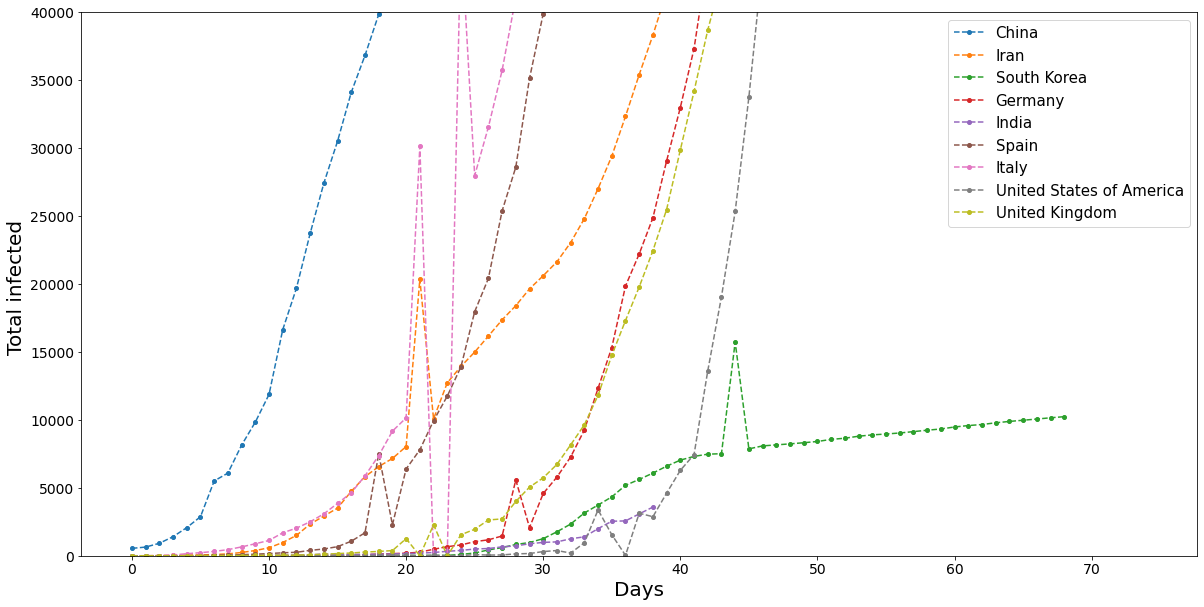

In [48]:
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
ax1.set_ylabel('Total infected ',fontsize=20)
ax1.set_xlabel('Days',fontsize=20)
ax1.set_ylim(0,40000)
for loc in range(len(Countries)):
  Country = df_summary.loc[loc].Country
  df_country = df1.loc[Country]
  df_country.reset_index(inplace=True)
  orig = df_country['Confirmed'].tolist()
  coeff1, coeff2 = df_summary.loc[loc].First_Coeff, df_summary.loc[loc].Doubling_time_in_days
  print(Country, coeff1, coeff2)
  predictions = []
  for i in range(48):
    yfit = coeff1*2**(i/coeff2)
    predictions.append(yfit)
  ax1.plot(orig,'--o',ms=4,label=Country)
  #ax1.plot(yfit,'--',label=f'Exponential fit')
  #plt.plot(predictions, label='predictions')
  ax1.legend(fontsize=15)

And now the bad but necessary task of prediction--change `loc` to see a different country. 

India 7.319577546364976 4.242164124846834


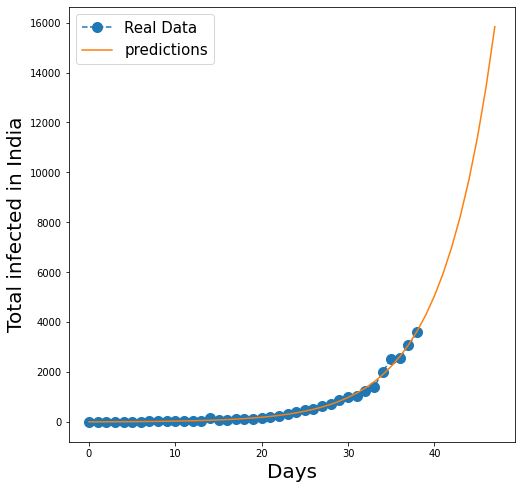

In [20]:
loc = 4
Country = df_summary.loc[loc].Country
df_country = df1.loc[Country]
df_country.reset_index(inplace=True)
orig = df_country['Confirmed'].tolist()
coeff1, coeff2 = df_summary.loc[loc].First_Coeff, df_summary.loc[loc].Doubling_time_in_days
print(Country, coeff1, coeff2)
predictions = []
for i in range(48):
  yfit = coeff1*2**(i/coeff2)
  predictions.append(yfit)

fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
ax1.set_ylabel('Total infected in '+Country,fontsize=20)
ax1.set_xlabel('Days',fontsize=20)
ax1.plot(orig,'--o',ms=10,label='Real Data')
#ax1.plot(yfit,'-',label=f'Exponential fit')
plt.plot(predictions, label='predictions')
ax1.legend(fontsize=15)

### Compare doubling time

Investigating how the doubling time is changing gives an idea how good or bad a country is doing in controlling the virus spread--
* A large doubling time is good.
* A constant doubling time - means the measures being taken are effective in controlling the spread
* An increasing doubling time means - the battle is on winning side
* A decreasing doubling time-- well danger zone ahead.  Do something fast

In [0]:
from scipy.optimize import curve_fit
def prediction_country2(Country, df1, plot=True,predict=False):
  df_final = df1.copy()
  df_country = df_final.loc[Country]
  df_country.reset_index(inplace=True)
    
  x=np.array(range(df_country.shape[0]))
  y=df_country['Confirmed'].values
  #print(len(x))

 
  def func(x,a,b):
    return a*2**(x/b)
  
  list_coeff = [Country]  
  for i in range(10, len(x), 1):
    xdata = x[:i]
    ydata = y[:i]

    try:
      popt, pcov = curve_fit(func,xdata=xdata,ydata=ydata)
    except:
      popt = np.array([0,0])
    list_coeff.append(popt[1])
  if plot:
    fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
    perc = np.diff(ydata) / ydata[:-1]
    yfit = popt[0]*2**(xdata/popt[1])
    perc_fit = np.diff(yfit) / yfit[:-1]
    ax1.set_ylabel('Total infected in '+ Country,fontsize=20)
    #ax1.set_yscale('log')
    ax1.plot(df_country['Confirmed'],'--o',ms=10,label='Real Data')
    ax1.plot(xdata,yfit,'-',label=f'Exponential fit {round(popt[0],1)}*2^(t/{round(popt[1],1)}), \n doubling time = {round(popt[1],1)} days')
    ax1.legend(fontsize=15)
    plt.show()
  if predict:
    x_new = [range(60)]
    predict_result = np.asarray([func(i, popt[0],popt[1]) for i in x_new])
    fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
    perc = np.diff(ydata) / ydata[:-1]
    yfit = predict_result
    #perc_fit = np.diff(yfit) / yfit[:-1]
    ax1.set_ylabel('Total infected in '+ Country,fontsize=20)
    #ax1.set_yscale('log')
    ax1.plot(df_country['Confirmed'],'--o',ms=10,label='Real Data')
    ax1.plot(yfit,'-',label=f'Exponential fit')
    ax1.legend(fontsize=15)
    plt.show()

  return list_coeff


In [22]:
Countries = ["China", "Iran", "South Korea", "Germany", "India", "Spain", "Italy", "United States of America", "United Kingdom"]
List = []
for Country in tqdm(Countries):
  coeff = prediction_country2(Country, df1,plot=False)
  List.append(coeff)

100%|██████████| 9/9 [00:00<00:00, 12.42it/s]


In [0]:
df_combines = pd.DataFrame(List).T

In [0]:
df_combines.columns = df_combines.iloc[0]
df_combines.drop(df_combines.index[0], inplace=True)

In [0]:
#df_combines
#Uncomment it if you like me want to see numbers.

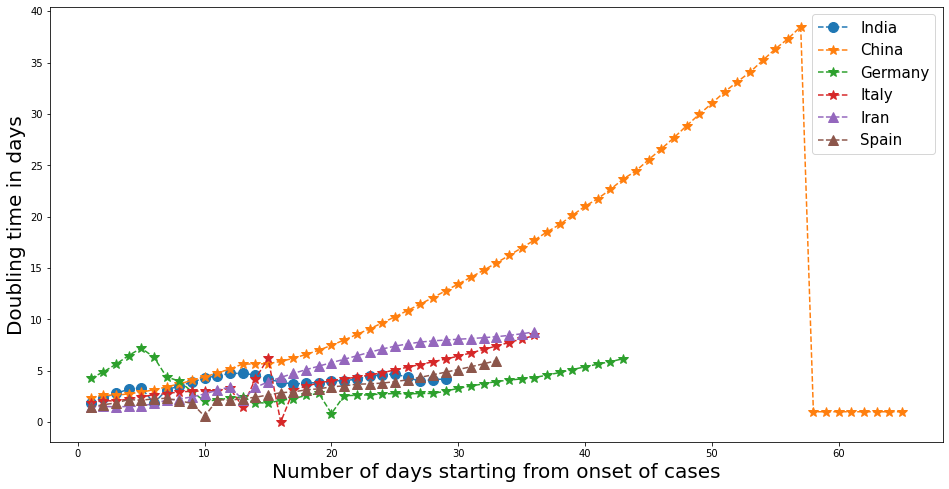

In [26]:
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time in days',fontsize=20)
ax1.set_xlabel('Number of days starting from onset of cases',fontsize=20)
ax1.plot(df_combines['India'],'--o',ms=10,label='India')
ax1.plot(df_combines['China'],'--*',ms=10,label='China')
ax1.plot(df_combines['Germany'],'--*',ms=10,label='Germany')
ax1.plot(df_combines['Italy'],'--*',ms=10,label='Italy')
ax1.plot(df_combines['Iran'],'--^',ms=10,label='Iran')
ax1.plot(df_combines['Spain'],'--^',ms=10,label='Spain')
ax1.legend(fontsize=15)
#plt.show()

Let us zoom the graph a little

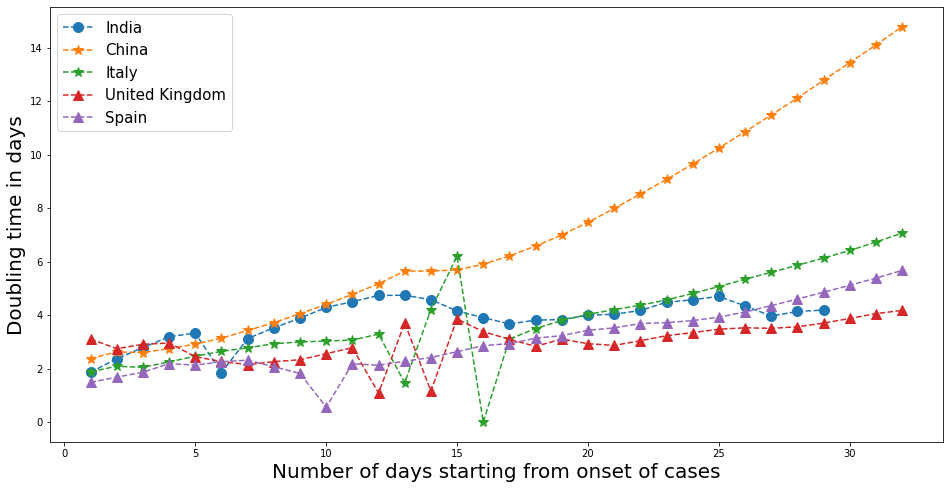

In [27]:
num = 32
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time in days',fontsize=20)
ax1.set_xlabel('Number of days starting from onset of cases',fontsize=20)
ax1.plot(df_combines['India'],'--o',ms=10,label='India')
ax1.plot(df_combines['China'].iloc[:num],'--*',ms=10,label='China')
#ax1.plot(df_combines['Germany'].iloc[:num],'--*',ms=10,label='Germany')
ax1.plot(df_combines['Italy'].iloc[:num],'--*',ms=10,label='Italy')
#ax1.plot(df_combines['Iran'].iloc[:num],'--^',ms=10,label='Iran')
ax1.plot(df_combines['United Kingdom'].iloc[:num],'--^',ms=10,label='United Kingdom')
ax1.plot(df_combines['Spain'].iloc[:num],'--^',ms=10,label='Spain')
#ax1.plot(df_combines['United States of America'].iloc[:num],'--^',ms=10,label='United States of America')
ax1.legend(fontsize=15)
#plt.show()

### What next? Are we moving in the right direction?

And now finally inspired from the [video](https://www.youtube.com/watch?v=54XLXg4fYsc&feature=youtu.be&fbclid=IwAR3H_-ZPnN6oClslsCP8_QykkTfto0wnJG7zt4WCJema2gNoG9kVVRazHnc) posted in the [FB group](https://www.facebook.com/groups/covid19global/) , I made this code to measure weekly and daily increase--the results shows all countries lie in a band-- and those who are winning the battle take a jump down.

*Almost like conduction band-valence band*

In [0]:
from scipy.optimize import curve_fit
def prediction_country3(Country, df1, plot=True,predict=False):
  df_final = df1.copy()
  df_country = df_final.loc[Country]
  df_country.reset_index(inplace=True)
  df_country['weekly_increase'] = (df_country['Confirmed']/ df_country['Confirmed'].shift(7) - 1) * 100
  df_country['daily_increase'] = (df_country['Confirmed'] / df_country['Confirmed'].shift(1) - 1) * 100

  
  x=np.array(range(df_country.shape[0]))
  y=df_country['Confirmed'].values
  #print(len(x))

 
  def func(x,a,b):
    return a*2**(x/b)
  
  list_coeff = np.zeros(df_country.shape[0]) #[Country]  
  for i in range(10, len(x), 1):
    xdata = x[:i]
    ydata = y[:i]

    try:
      popt, pcov = curve_fit(func,xdata=xdata,ydata=ydata)
    except:
      popt = np.array([0,0])
    list_coeff[i] = popt[1]
  if plot:
    fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
    perc = np.diff(ydata) / ydata[:-1]
    yfit = popt[0]*2**(xdata/popt[1])
    perc_fit = np.diff(yfit) / yfit[:-1]
    ax1.set_ylabel('Total infected in '+ Country,fontsize=20)
    #ax1.set_yscale('log')
    ax1.plot(df_country['Confirmed'],'--o',ms=10,label='Real Data')
    ax1.plot(xdata,yfit,'-',label=f'Exponential fit {round(popt[0],1)}*2^(t/{round(popt[1],1)}), \n doubling time = {round(popt[1],1)} days')
    ax1.legend(fontsize=15)
    plt.show()
  if predict:
    x_new = [range(60)]
    predict_result = np.asarray([func(i, popt[0],popt[1]) for i in x_new])
    fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
    perc = np.diff(ydata) / ydata[:-1]
    yfit = predict_result
    #perc_fit = np.diff(yfit) / yfit[:-1]
    ax1.set_ylabel('Total infected in '+ Country,fontsize=20)
    #ax1.set_yscale('log')
    ax1.plot(df_country['Confirmed'],'--o',ms=10,label='Real Data')
    ax1.plot(yfit,'-',label=f'Exponential fit')
    ax1.legend(fontsize=15)
    plt.show()
  list_coeff = np.asarray(list_coeff)
  df_country["Doubling_time"] = list_coeff
  df_country["Country"] = [Country  for _ in range(df_country.shape[0])]
  return df_country


In [0]:
Countries = ["China", "Iran", "South Korea", "Germany", "India", "Spain", "Italy"]
#Countries = set(df1.reset_index()['Country/Region'].tolist())

100%|██████████| 7/7 [00:00<00:00,  8.24it/s]


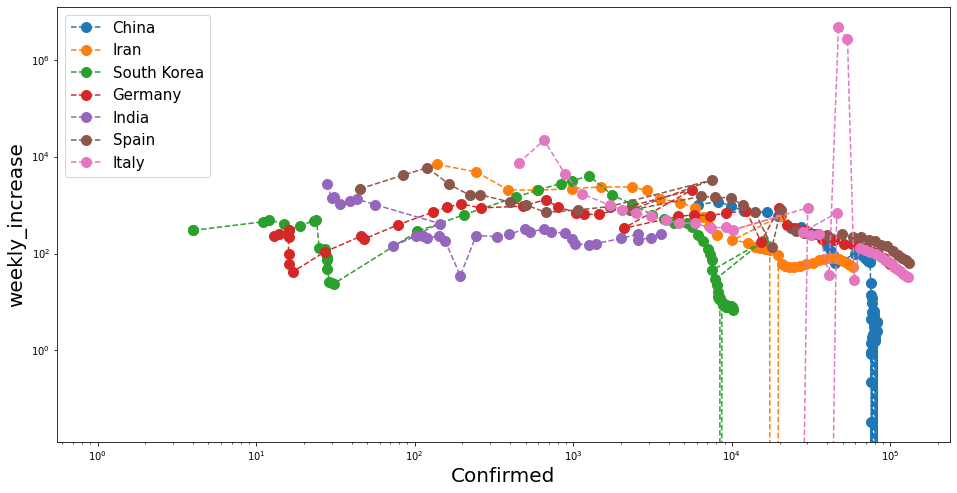

In [30]:
dff = pd.DataFrame(columns=['Country', "Doubling_time"])
Column = "weekly_increase"
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel(Column,fontsize=20)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Number of days starting from onset of cases',fontsize=20)

for Country in tqdm(Countries):
  dff2 = prediction_country3(Country, df1,plot=False)
  dff2.plot("Confirmed", "weekly_increase", ls='--', marker='o', ax=ax1, ms=10,label=Country)

  dff = pd.merge(dff,dff2, how='outer')
ax1.legend(fontsize=15)

### And now view the data on world map

In [31]:
world_path = gpd.datasets.get_path('naturalearth_lowres')
World = gpd.read_file(world_path)
World.columns = ['pop_est', 'continent', 'Country', 'iso_a3', 'gdp_md_est', 'geometry']
print(len(World['Country']))
World = pd.merge(World, df_summary, on='Country',how='left')
World["Total_per_pop"] = World['Total_Confirmed_Today']/World['pop_est']*100
World.fillna(0,inplace=True)

177


Text(0.5, 1.0, 'Total number of Covid confirmed per population as on 04-05-2020')

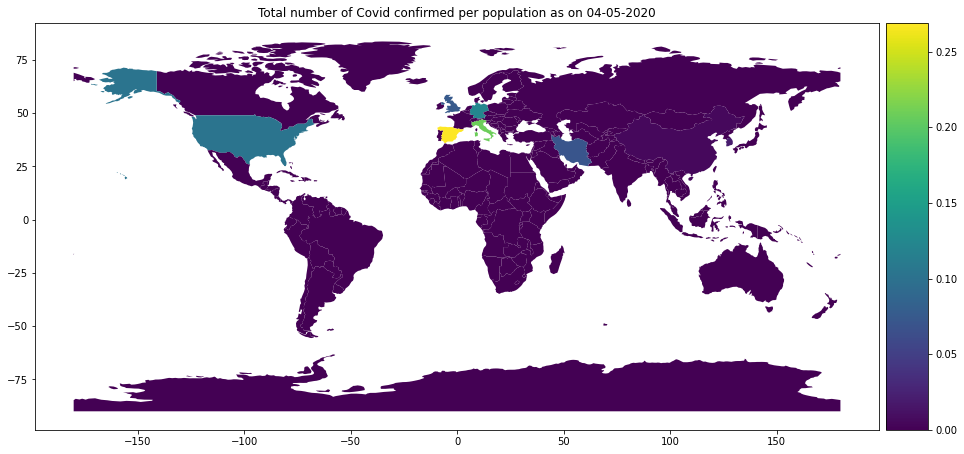

In [32]:
title = "Total_per_pop"
description = "Covid 19 cases world wide"
from mpl_toolkits.axes_grid1 import make_axes_locatable
#World = World[(World.Total_Confirmed_Today>10) & (World.Doubling_time_in_days < 30) & (World.Doubling_time_in_days > 0)]
fig, ax = plt.subplots(1, 1, figsize=(16,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
World.plot(column =title, ax=ax,
            legend=True, cax=cax)
ax.set_title("Total number of Covid confirmed per population as on "+dates[-1])

Text(0.5, 1.0, 'Total number of Covid confirmed as on 04-05-2020')

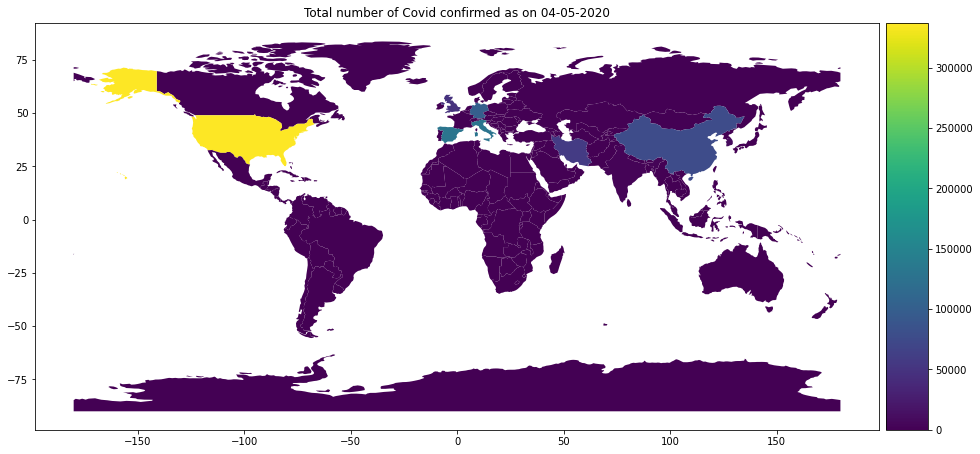

In [33]:
title = "Total_Confirmed_Today"
description = "Covid 19 cases world wide"
from mpl_toolkits.axes_grid1 import make_axes_locatable
#World = World[(World.Total_Confirmed_Today>10) & (World.Doubling_time_in_days < 30) & (World.Doubling_time_in_days > 0)]
fig, ax = plt.subplots(1, 1, figsize=(16,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
World.plot(column =title, ax=ax,
            legend=True, cax=cax)
ax.set_title("Total number of Covid confirmed as on "+dates[-1])

Text(0.5, 1.0, 'Deceased Percentage as on 04-05-2020')

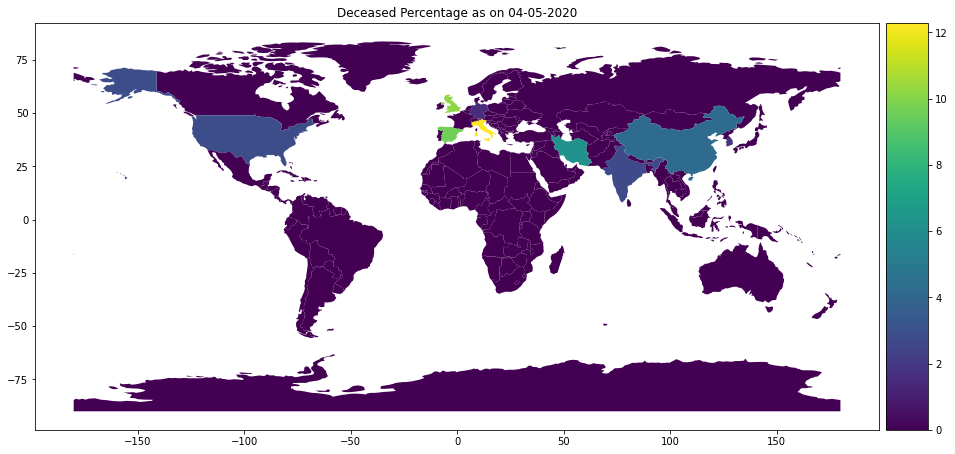

In [34]:
title = "Deceased_Percent"
description = "Covid 19 cases world wide"
from mpl_toolkits.axes_grid1 import make_axes_locatable
#World = World[(World.Total_Confirmed_Today>10) & (World.Doubling_time_in_days < 30) & (World.Doubling_time_in_days > 0)]
fig, ax = plt.subplots(1, 1, figsize=(16,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
World.plot(column =title, ax=ax,
            legend=True, cax=cax)
ax.set_title("Deceased Percentage as on "+dates[-1])

Text(0.5, 1.0, 'Recovered Percentage as on 04-05-2020')

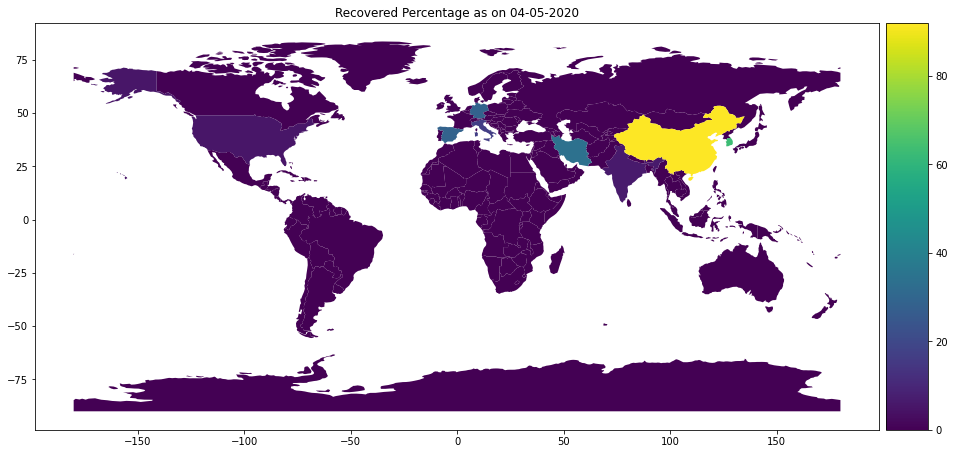

In [35]:
title = "Recovered_Percent"
description = "Covid 19 cases world wide"
from mpl_toolkits.axes_grid1 import make_axes_locatable
#World = World[(World.Total_Confirmed_Today>10) & (World.Doubling_time_in_days < 30) & (World.Doubling_time_in_days > 0)]
fig, ax = plt.subplots(1, 1, figsize=(16,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
World.plot(column =title, ax=ax,
            legend=True, cax=cax)
ax.set_title("Recovered Percentage as on "+dates[-1])

## Let ys play around now a little with with different countries

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


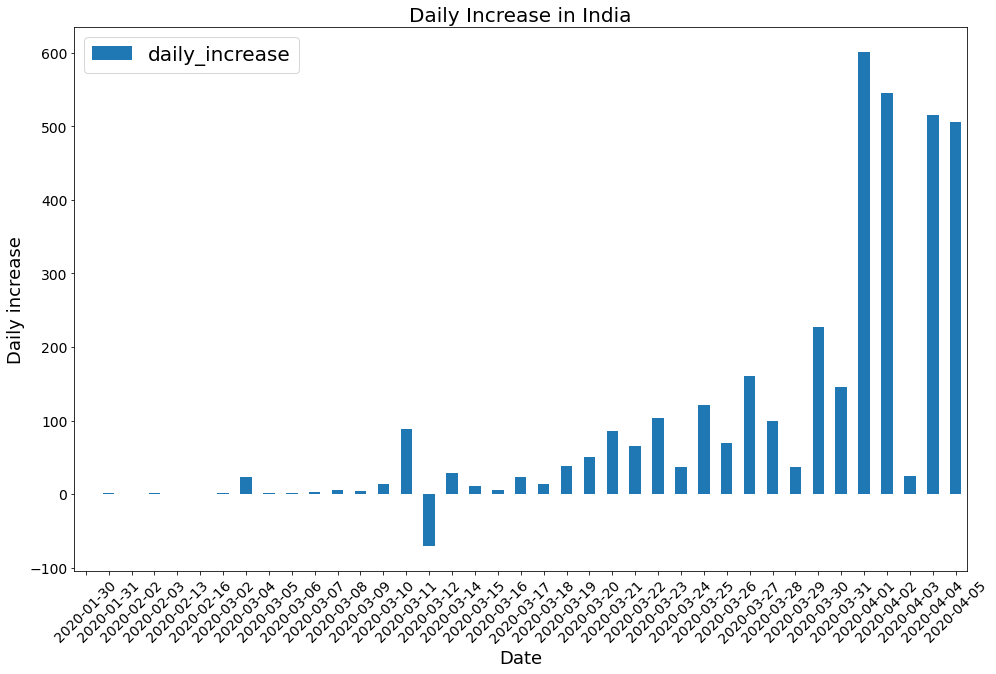

In [36]:
plot_total(df1,"India",'daily_increase')

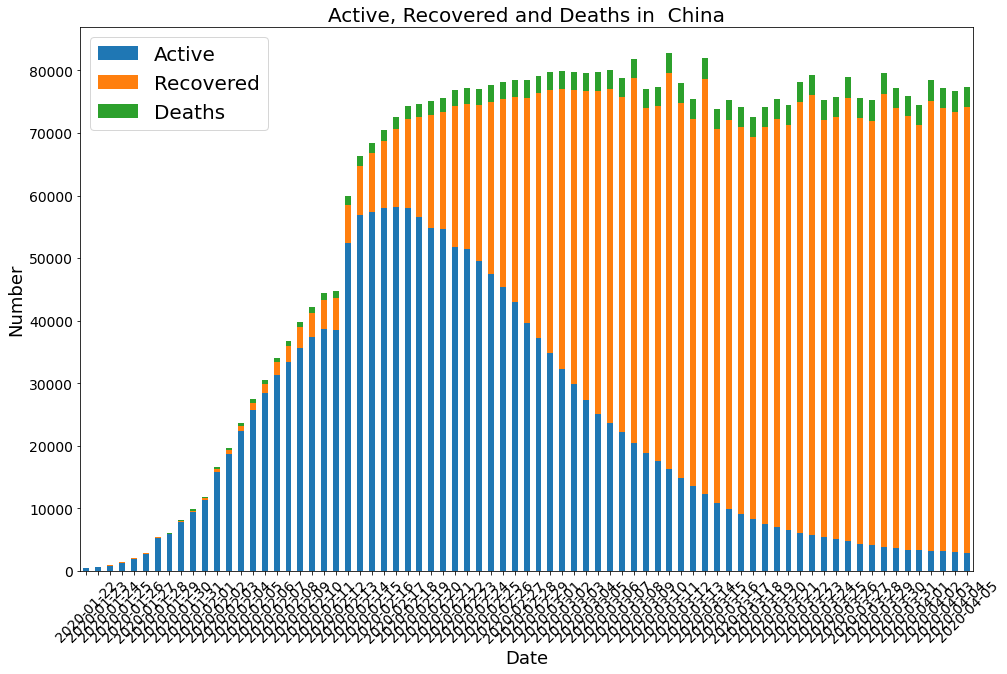

In [37]:
plot_total(df1,"China",bar=True)

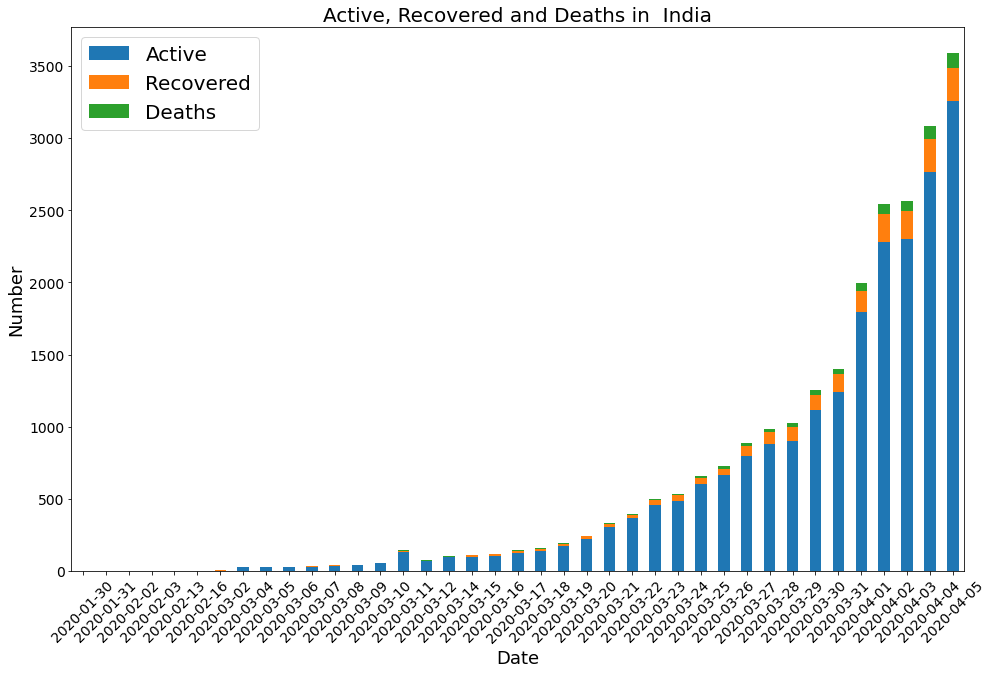

In [38]:
plot_total(df1,'India',bar=True)

## Finally SIR modelling

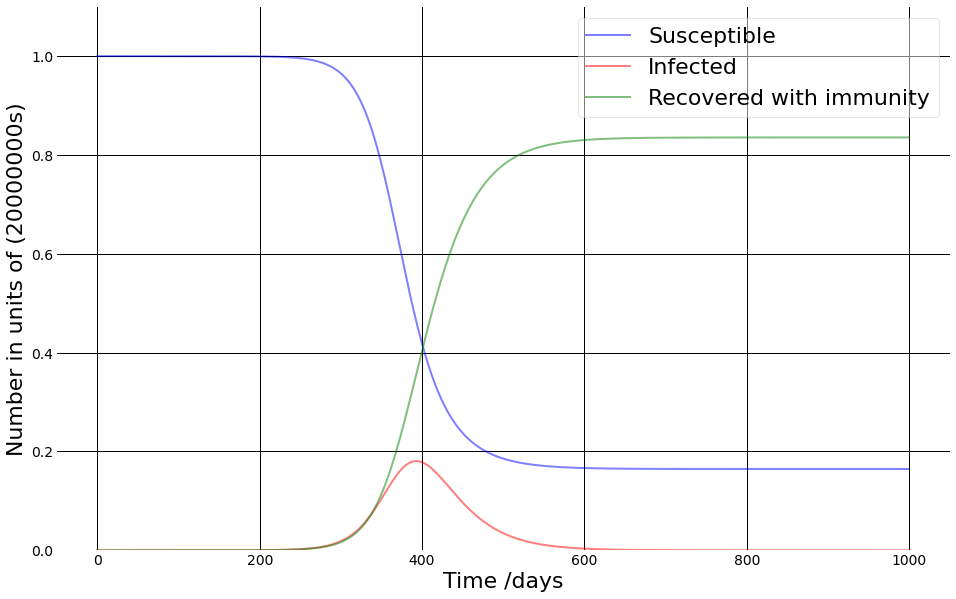

In [39]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 20000000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.08, 1/27    #  https://www.worldometers.info/coronavirus/coronavirus-incubation-period/#24
# A grid of time points (in days)
t = np.linspace(0, 1000, 360)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number in units of ('+str(N)+'s)')
ax.set_ylim(0,1.1)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='both',axis='both', c='black', lw=1, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

 # adapted code from:  https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

 # Reference: https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-contact-number

## Additional Data
Total number of tests done per country

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text major ticklabel objects>)

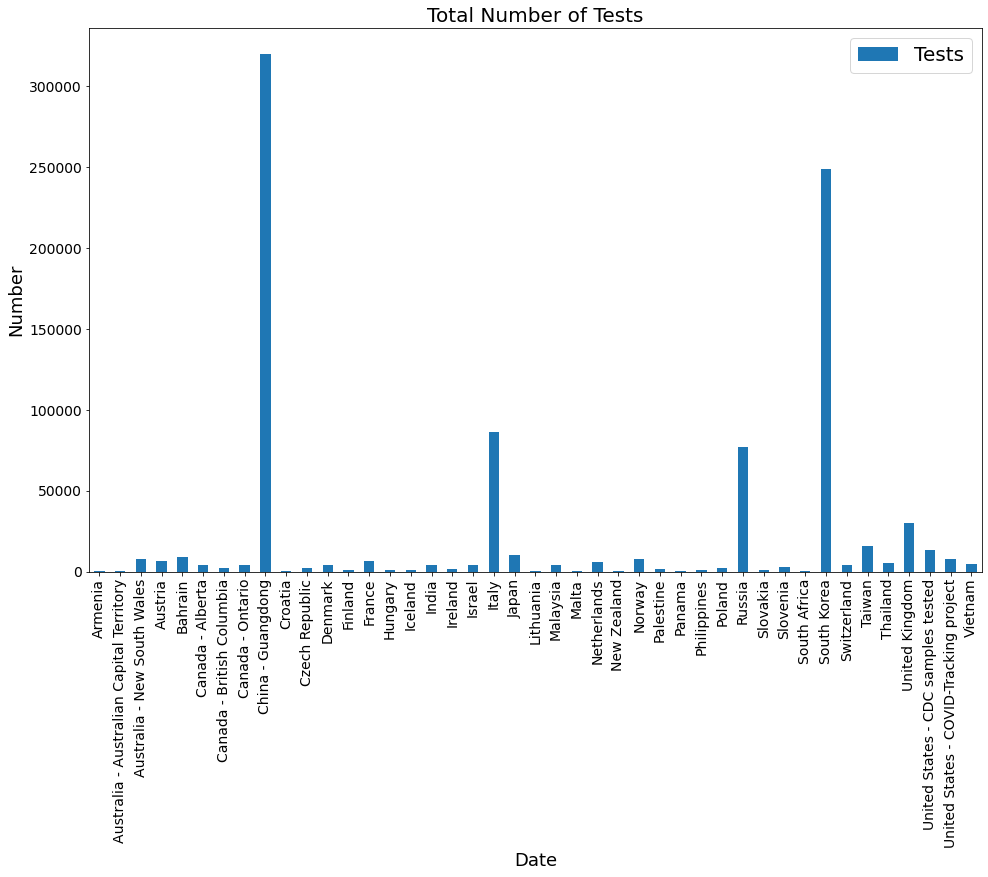

In [40]:
url_number_of_tests = 'https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/COVID-19%20Tests/COVID-19%20Tests.csv'
tests_df = pd.read_csv(url_number_of_tests )
tests_df.columns = ['Country','Year','Tests']
tests_df.set_index("Country", inplace = True)
tests_df.drop('Year', axis = 1, inplace = True)
ax = tests_df.plot.bar()
#ax = tests_df.plot.scatter(x='Country', y='Tests', s=tests_df['Tests'] * 200);
ax.set_ylabel("Number", fontname="Arial", fontsize=18)
ax.set_xlabel("Date", fontname="Arial", fontsize=18)
ax.legend(loc=0, prop={'size': 20})
ax.set_title("Total Number of Tests", fontsize=20)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text major ticklabel objects>)

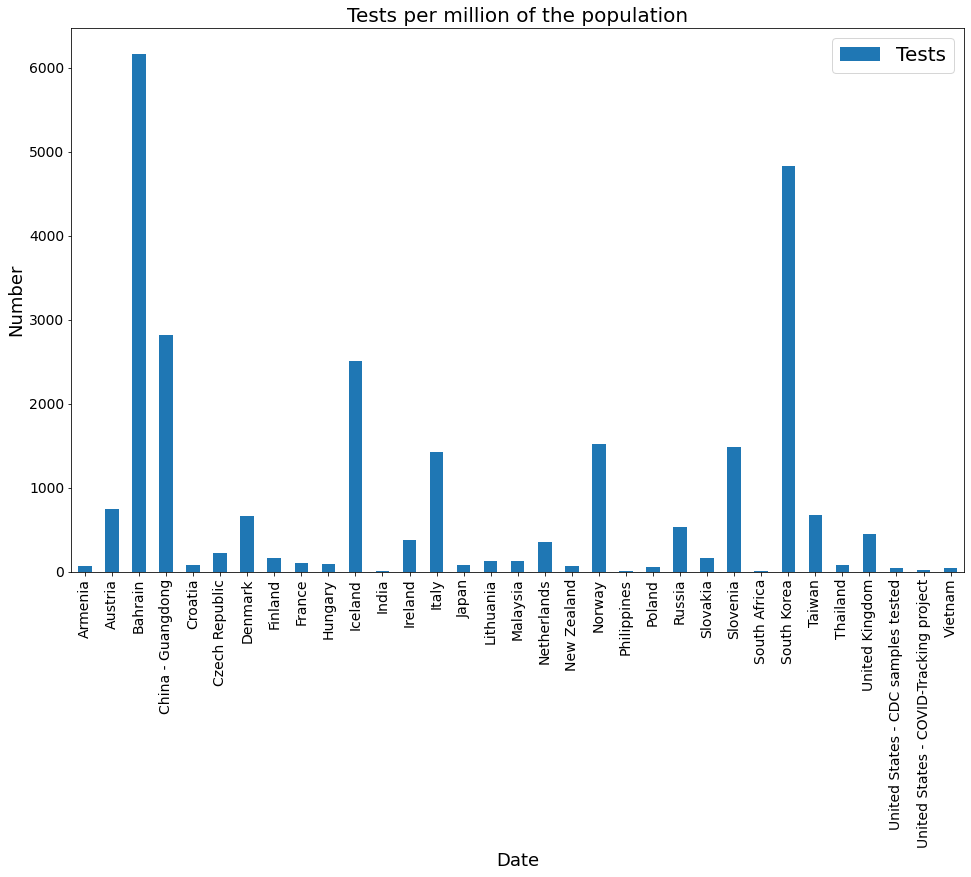

In [41]:
url_number_of_tests = 'https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/COVID-19%20Tests%20per%20million%20people/COVID-19%20Tests%20per%20million%20people.csv'
tests_df = pd.read_csv(url_number_of_tests )
tests_df.columns = ['Country','Year','Tests']
tests_df.set_index("Country", inplace = True)
tests_df.drop('Year', axis = 1, inplace = True)
ax = tests_df.plot.bar()
#ax = tests_df.plot.scatter(x='Country', y='Tests', s=tests_df['Tests'] * 200);
ax.set_ylabel("Number", fontname="Arial", fontsize=18)
ax.set_xlabel("Date", fontname="Arial", fontsize=18)
ax.legend(loc=0, prop={'size': 20})
ax.set_title("Tests per million of the population", fontsize=20)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text major ticklabel objects>)

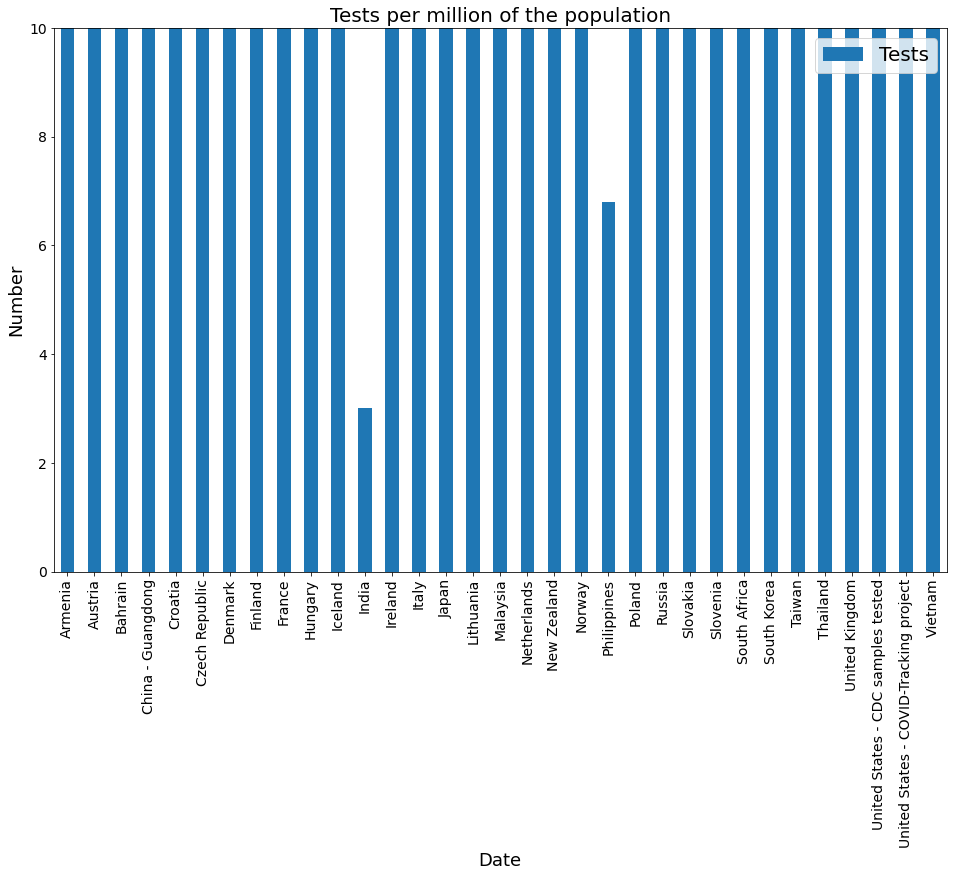

In [42]:
ax = tests_df.plot.bar()
#ax = tests_df.plot.scatter(x='Country', y='Tests', s=tests_df['Tests'] * 200);
ax.set_ylabel("Number", fontname="Arial", fontsize=18)
ax.set_xlabel("Date", fontname="Arial", fontsize=18)
ax.legend(loc=0, prop={'size': 20})
ax.set_ylim(0,10)
ax.set_title("Tests per million of the population", fontsize=20)
plt.xticks(rotation=90)